# Camera Calibration 
### Done By: Abhinav Gupta, 20171059
Implementing and comparing two very popular camera calibration techniques: DLT and Zhang's method. We also test the quality of the parameters estimated from these calibration methods. 

## Direct Linear Transform
### Implementation
- We perform DLT based calibration on a given image and estimate the camera parameters. 
- We use 20-30 different points on different planes and report the projection, camera, rotation matrices and the projection center.  
- The given image is 'calib-object.jpg'. We need to manually estimate the image coordinates by referring to 'calib-object-legend.jpg' for world measurements. 

- First, let's import all the libraries we need. 

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg
from numpy import linalg as LA
import glob
import math
import random

- We need to perform camera calibration on 'calib-object.jpg'

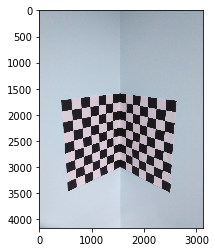

In [4]:
img1 = cv2.imread('./data/calib-object.jpg')
plt.imshow(img1)

### 3D - 2D correspondences - Control Points
- First, we manually compute the 2D-3D correspondences by plotting the image, and moving the cursor around to get the pixel coordinates.  
`img = plt.imread('calib-object.jpg')` \
`plt.imshow(img)` 


We choose the following control points (computed manually), and their corresponding 2D pixel locations.
- (0,0,0) - (1549, 1599)
- (0,28,0) - (1547, 1763)
- (56,0,0) - (1797, 1625)
- (56,28,0) - (1793, 1807)
- (56,84,0) - (1785, 2156)
- (84,84,0) - (1918, 2196)
- (112,56,0) - (2069, 2051)
- (112,84,0) - (2061, 2233)
- (84,56,0) - (1928, 2015)
- (84,112,0) - (1915, 2366)
- (0,28,28) - (1413, 1781)
- (0,28,56) - (1280, 1807)
- (0,56,28) - (1415, 1958)
- (0,56,56) - (1283, 1981)
- (0,56,84) - (1139, 2013)
- (0,56,112) - (990, 2041)
- (0,112,0) - (1541, 2251)
- (0,112,28) - (1420, 2287)
- (0,112,56) - (1292, 2320)
- (0,112,84) - (1149, 2356)
- (0,112,112) - (1005, 2401)

Let's make two arrays: worldcoo and imagecoo, that contain the control points and their 2D locations respectively. 

In [5]:
worldcoo = [ (0,0,0), (0,28,0), (56,0,0), (56,28,0), (56,84,0), (84,84,0), (112,56,0),
             (112,84,0), (84,56,0), (84,112,0), (0,28,28), (0,28,56), (0,56,28), (0,56,56), 
             (0,56,84), (0,56,112), (0,112,0), (0,112,28), (0,112,56), (0,112,84), (0,112,112) 
           ]

imagecoo = [ (1549, 1599), (1547, 1763), (1797, 1625), (1793, 1807), (1785, 2156), (1918, 2196),
             (2069, 2051), (2061, 2233), (1928, 2015), (1915, 2366), (1413, 1781), (1280, 1807),
             (1415, 1958), (1283, 1981), (1139, 2013), (990, 2041), (1541, 2251), (1420, 2287),
             (1292, 2320), (1149, 2356), (1005, 2401)
           ]

### Building the DLT Matrix (2n x 12)
- Here, n=21 because we choose 21 points, and we get 2 (1x12) vectors corresponding to each point. 
- So each point two rows associated with it, and there are totally 21 points, hence 42 rows. 
- Therefore, our DLT matrix will be of dimensions (42x12)

- The `create_row1` function returns the first (1x12) vector for a 3D world point and its corresponding image coordinates.

In [6]:
def create_row1(world, image):
    x = []
    x = np.array(x)
    
    e1 = -1*world[0]
    e2 = -1*world[1]
    e3 = -1*world[2]
    
    x = np.append(x, (e1,e2,e3))
    x = np.append(x, (-1,0,0,0,0))
    
    e9 = image[0]*world[0] 
    e10 = image[0]*world[1] 
    e11 = image[0]*world[2] 
    e12 = image[0]
    x = np.append(x, (e9,e10,e11,e12))
    return x

- Similarly, the `create_row2` function returns the second (1x12) vector for the 3D world point and its corresponding image coordinates.

In [7]:
def create_row2(world, image):
    y = []
    y = np.array(y)
    y = np.append(y, (0,0,0,0))
    
    e5 = -1*world[0]
    e6 = -1*world[1]
    e7 = -1*world[2]
    y = np.append(y, (e5,e6,e7,-1))
    
    e9 = image[1]*world[0] 
    e10 = image[1]*world[1] 
    e11 = image[1]*world[2] 
    e12 = image[1]
    y = np.append(y, (e9,e10,e11,e12))
    return y

- We take all the 21 points one by one, create the (2x12) matrix for each, and stack them on top of each other to obtain the final DLT matrix of dimensions (2nx12).

In [8]:
dlt_mat = []
dlt_mat = np.array(dlt_mat)

for i in range(0,21):
    row1 = create_row1(worldcoo[i], imagecoo[i])
    row2 = create_row2(worldcoo[i], imagecoo[i])
    dlt_mat = np.append(dlt_mat, row1)
    dlt_mat = np.append(dlt_mat, row2)
print(dlt_mat.shape)

(504,)


- We get a (504x1) vector, which is correct, as we had 21 points and each point yielded (2x12) = 24 values. So 24x21 = 504 values. 
- We need to reshape this into a (2nx12) = (42x12) matrix, where each couple of rows correspond to a single world point.

In [9]:
dlt_mat = dlt_mat.reshape(42, 12)
print(dlt_mat.shape)

(42, 12)


## Solving the linear system of equations by SVD
- Now that we have our DLT matrix, we need to solve the linear system of equations to obtain the camera parameters such that Mp = 0, where M is `dlt_mat'
- We do this by applying singular value decomposition (SVD) to `dlt_mat`. 
- `M = U S V.T` 
- The solution is the last column of V

In [10]:
U, S, V = np.linalg.svd(dlt_mat)

In [11]:
P = V[-1,:]
P = np.array(P)
P = np.reshape(P,(3,4))
with np.printoptions(suppress=True): print('The Projection matrix is \n',P)

The Projection matrix is 
 [[-0.00106739 -0.00031384  0.00275453 -0.69612992]
 [ 0.00060642 -0.00311488  0.00049928 -0.71790235]
 [ 0.00000053 -0.00000021  0.00000047 -0.00045042]]


In [12]:
H = P[:3,:3]
Q, R = np.linalg.qr(np.linalg.inv(H))
# K, R = linalg.rq(H)
Rotation = Q.T
K = np.linalg.inv(R)
K = K/K[2,2]
t = np.dot(-1*np.linalg.inv(H), P[:,3])

In [13]:
with np.printoptions(suppress=True): print('The Intrinsic matrix is \n',K)

The Intrinsic matrix is 
 [[3747.98123092  -16.40665733 1436.9755183 ]
 [   0.         3736.05884976 2209.63419683]
 [   0.            0.            1.        ]]


In [14]:
with np.printoptions(suppress=True): print('The Rotation matrix is \n',Rotation)

The Rotation matrix is 
 [[-0.66194001 -0.00873237  0.74950595]
 [-0.20678851 -0.95899906 -0.19380223]
 [ 0.72046786 -0.28327467  0.63299409]]


In [15]:
with np.printoptions(suppress=True): print('The Translation matrix is \n',t)

The Translation matrix is 
 [447.8469299  -76.35450855 417.56436528]


#### Let's also just check once if our projection matrix is corect or not :P
- Projection matrix is (3x4). 
- One of our world points, in homogeneous coordinates is (84,112,0,1) - (4x1). 
- Let's multiply P with the world point to get the image coordinates. 

In [16]:
point = [84,112,0,1]
point = np.array(point)
xycoo = np.dot(P, point)
xycoo = xycoo/xycoo[2]
with np.printoptions(suppress=True): print(xycoo)

[1913.12239372 2367.29243229    1.        ]


### ^ The original point was (1915, 2366), Looks good ^_^
- Now let's see how many points are projected correctly (with minimum error) using this projection matrix.
- First, we need to append ones to the image and world coordinates, that is, (84,112,0) becomes (84,112,0,1)

In [17]:
ones = np.ones((21,1))
imagecoo = np.array(imagecoo)
imagecoo_new = np.hstack((imagecoo, ones))

worldcoo = np.array(worldcoo)
worldcoo_new = np.hstack((worldcoo, ones))

- Now we loop through all our 3D points and using the projection matrix, project it back to 2D.
- Then, we compare it with the actual 2D coordinates using `np.linalg.norm`
- If the error is minimal (below a threshold value), we accept that the point has been projected correctly! 

In [18]:
ctr = 0
for i in range(0,21):
    expected = np.dot(P, worldcoo_new[i])
    expected = expected/expected[2]
    actual = imagecoo_new[i]
    error = abs(np.linalg.norm(expected) - np.linalg.norm(actual))
    if(error<1.5):
        ctr += 1;

In [19]:
print("Points projected correctly: ", ctr)

Points projected correctly:  13


## RANSAC
- What we did above was check the accuracy of the projection matrix. 
- We use similar logic for the RANSAC loop!
- We randomly pick 6 (2D-3D) correspondences and compute the projection matrix by applying DLT. 
- We then check the accuracy of this projection matrix. 
- We keep doing for `RANSAC_TIMES` and pick the best projection matrix! :) 

- So let's just write a `compute_DLT` function, which takes as input the 2D-3D correspondences and outputs the projection matrix. 
- This will be useful for the RANSAC loop. 

In [20]:
def compute_DLT(worldcoo, imagecoo):
    dlt_mat = []
    dlt_mat = np.array(dlt_mat)

    # build the (2nx12) matrix
    for i in range(0,len(worldcoo)):
        row1 = create_row1(worldcoo[i], imagecoo[i])
        row2 = create_row2(worldcoo[i], imagecoo[i])
        dlt_mat = np.append(dlt_mat, row1)
        dlt_mat = np.append(dlt_mat, row2)
    
    dlt_mat = dlt_mat.reshape(2*len(worldcoo), 12)
    
    # SVD time!
    U, S, V = np.linalg.svd(dlt_mat)
    P = V[-1,:]
    P = np.array(P)
    P = np.reshape(P,(3,4))
    return P   

### RANSAC loop
- We have 21 point correspondences. Since we need minimum 6 for applying DLT, let's pick any 6 correspondences at random and apply DLT. 
- We keep doing this until our error minimizes. 

In [56]:
def RANSAC_LOOP(world, image):
    RANSAC_TIMES = 10
    num_vals = len(world)
    best_P = None
    best_ctr = 1
    best_itr = -1
    
    # appending ones to the world and image coordinates to make them homogeneous 
    ones = np.ones((len(world),1))
    image_homo = np.hstack((image, ones))
    world_homo = np.hstack((world, ones))
    
    for i in range(RANSAC_TIMES):
        # Choose random 6 2D-3D correspondences.
        rand_choice = [random.randint(0, num_vals-1) for x in range(9)]
        world_input = [world[x] for x in rand_choice]
        image_input = [image[x] for x in rand_choice]
        
        world_input = np.array(world_input)
        image_input = np.array(image_input)
        
        # Let's compute the projection matrix after applying DLT for these 6 random correspondences.
        P = compute_DLT(world_input, image_input)
        
        ''' 
        There's a possibility that all the points were lying on the same plane. 
        In such a scenario, our projection matrix would be a singular matrix. 
        We need to avoid such cases. 
        '''
        
        # Now let's see if this matrix is any good. Let's compute the error in projection!
        ctr = 0
        for j in range(0,len(world_homo)):
            expected = np.dot(P, world_homo[j])
            expected = expected/expected[2]
            actual = image_homo[j]
            
            error = abs(np.linalg.norm(expected) - np.linalg.norm(actual))
            if(error < 1.5):
                ctr += 1;
        
        print(i,". Number of Points correctly projected: ", ctr )
        if(ctr>best_ctr):
            best_ctr = ctr
            best_P = P
            best_itr = i
    
    return best_P, best_itr

In [57]:
best1, best_itr = RANSAC_LOOP(worldcoo, imagecoo)

0 . Number of Points correctly projected:  10
1 . Number of Points correctly projected:  13
2 . Number of Points correctly projected:  10
3 . Number of Points correctly projected:  6
4 . Number of Points correctly projected:  7
5 . Number of Points correctly projected:  11
6 . Number of Points correctly projected:  11
7 . Number of Points correctly projected:  15
8 . Number of Points correctly projected:  13
9 . Number of Points correctly projected:  11


In [58]:
print("\n The best projection matrix we get is: \n")
with np.printoptions(suppress=True): print(best1)
print("\n and this corresponds to iteration number ", best_itr)


 The best projection matrix we get is: 

[[-0.00105006 -0.00035273  0.00281324 -0.69672092]
 [ 0.00061762 -0.00317766  0.0005726  -0.71732824]
 [ 0.00000054 -0.00000024  0.00000051 -0.00045073]]

 and this corresponds to iteration number  7


## Zhang's Method
- We use the checkerboard images given to us and perform camera calibration using Zhang's method. 
- Special thanks to the tutorial take prior, because that really helped with this part! 
- First, let's load the chessboard image. 

In [21]:
img1 = cv2.imread('./data/IMG_5456.jpg')

- Now let's find the corner points in the checker-board - the image we just loaded. 
- The dimensions are (8x6).
- We use the inbuilt `cv2.findChessboardCorners`. No clue how it works though, I just blackboxed it in my mind! 
- All I know is that the function returns the corner points and return value which will be True if the pattern is obtained. These corners will be placed in an order (from left-to-right, top-to-bottom). 
- The return value returned by the function is True if the checkerboard was completely detected and False if partially detected.

In [22]:
ret, corners = cv2.findChessboardCorners(img1,(8,6))
corners = corners.reshape(-1,2)
print (corners.shape)
print (corners[0])

(48, 2)
[1070.5607  582.6061]


- Now let's visualise these image points. 
- No need for this, but they did it in the tutorial and it was fun! 

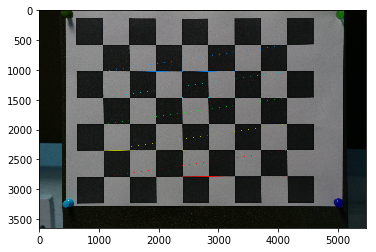

True

In [23]:
img_vis = img1.copy()
cv2.drawChessboardCorners(img_vis, (8,6), corners, ret) 
plt.imshow(img_vis)
plt.show()
cv2.imwrite('./data/vis.jpg', img_vis)

### ^ Looks pretty good, corners get detected beautifully <3 

- Now let's define the corresponding 3D world points.
- For simplicity, we can say that the chessboard was kept stationary at XY plane (so Z=0 always), and camera was moved. This consideration helps us to find only X,Y values.
- Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points.
- So we create a meshgrid which will give us **all combinations of X-Y coordinates**

In [24]:
def generate_world_points(row, col):
    x,y = np.meshgrid(range(row),range(col))
    total = np.dot(row,col)
    x = x.reshape(total,1)
    y = y.reshape(total,1)
    world_points = np.hstack((x, y, np.zeros((total,1)))).astype(np.float32)
    return x, y, world_points

In [25]:
x, y, world_points = generate_world_points(8, 6)
print(world_points)

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [7. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [7. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [7. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [7. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]]


- So these world points now correspond to the corners that we computed using the inbuilt cv2 function. 
- For instance, here are the world points that correspond to the 1st and 30th corner points repectively!

In [26]:
print (corners[0],'->',world_points[0])
print (corners[30],'->',world_points[30])

[1070.5607  582.6061] -> [0. 0. 0.]
[3716.0671 1905.8381] -> [6. 3. 0.]


In [27]:
images = ['./data/IMG_5456.jpg', './data/IMG_5457.jpg', './data/IMG_5458.jpg', './data/IMG_5459.jpg', 
          './data/IMG_5460.jpg', './data/IMG_5461.jpg', './data/IMG_5462.jpg', './data/IMG_5463.jpg', 
          './data/IMG_5464.jpg', './data/IMG_5465.jpg', './data/IMG_5466.jpg', './data/IMG_5467.jpg',
          './data/IMG_5468.jpg', './data/IMG_5469.jpg', './data/IMG_5470.jpg'
         ]

In [66]:
def generate_image_points(images, world_points, dim1, dim2):
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    for i in images:
        im = cv2.imread(i)
        ret, corners = cv2.findChessboardCorners(im, (dim1,dim2))

        if ret: # checking if checkerboard was correctly detected:
            imgpoints.append(corners) # append current 2D points
            objpoints.append(world_points) # 3D points are always the same
#         else:
#             print("Checkerboard not detected in image number: ", i )
    return objpoints, imgpoints

In [28]:
objpoints, imgpoints = generate_image_points(images, world_points, 8, 6)

NameError: name 'generate_image_points' is not defined

- We have the image points and the object points! 
- Now let's use the `cv2.calibrateCamera` inbuilt function to get the camera parameters. 

In [68]:
imgpoints = np.array(imgpoints)
print(imgpoints.shape)

(15, 48, 1, 2)


In [69]:
def calibrate(images, objpoints, imgpoints):
    im = cv2.imread(images[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (im.shape[1], im.shape[0]), 
                                                       None, None)
    return mtx, dist, rvecs, tvecs
    

In [70]:
mtx, dist, rvecs, tvecs = calibrate(images, objpoints, imgpoints)

In [71]:
print('Reprojection Error:', ret)
print ('\nCamera Calibration Matrix:')
with np.printoptions(suppress=True): print(mtx)

Reprojection Error: True

Camera Calibration Matrix:
[[13663.47706115     0.          3336.53575505]
 [    0.         13681.38258706  1496.60065897]
 [    0.             0.             1.        ]]


In [72]:
print('\nDistortion Parameters:')
with np.printoptions(suppress=True): print(dist)

print('\nRotation Vectors for the images are:')
with np.printoptions(suppress=True): print(rvecs)

print('\nTranslation Vectors for the images are:')
with np.printoptions(suppress=True): print(tvecs)


Distortion Parameters:
[[   0.09521294   10.10927853   -0.0152798     0.02872131 -160.59001919]]

Rotation Vectors for the images are:
[array([[-0.01318089],
       [-0.05189252],
       [-0.00310183]]), array([[-0.00723373],
       [ 0.22652171],
       [ 0.03532858]]), array([[-0.00906864],
       [-0.41619657],
       [-0.03572075]]), array([[ 0.01633958],
       [-0.61839253],
       [-0.07755517]]), array([[0.00456622],
       [0.30778504],
       [0.06543949]]), array([[-0.32566618],
       [-0.22232068],
       [-0.01742856]]), array([[-0.19221716],
       [-0.38502421],
       [-0.00381478]]), array([[ 0.24427917],
       [-0.32262058],
       [ 0.02472158]]), array([[0.31114495],
       [0.06632946],
       [0.07053941]]), array([[ 0.34957369],
       [-0.56388409],
       [-0.06027059]]), array([[ 0.22457423],
       [-0.4058921 ],
       [-0.05699645]]), array([[-0.11332321],
       [-0.29806932],
       [ 0.00488493]]), array([[-0.38084113],
       [ 0.00764409],
       [ 

- Now let's visualise these reprojected points through a wireframe
- First , we need a function to convert the Rotation Matrix into the Euler Angles (ripped off from the internet somewhere xD)

In [73]:
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

In [74]:
r =  rvecs[4]
R = (eulerAnglesToRotationMatrix(r))
world_points_1 = np.hstack((x, y, np.zeros((48,1)), np.ones((48,1)))).astype(np.float32)

In [75]:
temp1 = np.zeros((3,4))
temp1[0:3,0:3] = R[0:3,0:3]
temp1[:,3] = tvecs[4][:,0]
print(temp1)

[[ 9.50967111e-01 -6.40117454e-02  3.02595524e-01 -4.81212655e+00]
 [ 6.23197827e-02  9.97939657e-01  1.52540113e-02 -2.12408300e+00]
 [-3.02948509e-01  4.35162422e-03  9.52996991e-01  3.26975979e+01]]


In [76]:
P = np.matmul(mtx,temp1)
P = P/P[2,3]
print(P)

[[ 3.66470920e+02 -2.63047967e+01  2.23692748e+02  1.32567303e+03]
 [ 1.22096997e+01  4.17758728e+02  5.00022019e+01  6.07838364e+02]
 [-9.26516103e-03  1.33086970e-04  2.91457799e-02  1.00000000e+00]]


In [78]:
projected_points = []
for i in range(48):
    projection = np.matmul(P,np.transpose(world_points_1[i,:]))
    projection = projection/projection[2]
    projected_points.append(projection[0:2])

projected_points = np.asarray(projected_points)

In [79]:
img1 = cv2.imread(images[4])

In [80]:
def generate_wireframe(idx, idx1, projected_points, img):
    q = 0
    p = 0
    for i in range(projected_points.shape[0]):
        if (i == idx[q]):
            q = q + 1
            continue
        plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')

    for i in range(len(idx)):
        i1 = i
        j =  i + len(idx1)
        while(j < (len(idx)*len(idx1))):
            plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')
            i1 = j
            j = j + len(idx1)
    plt.imshow(img)
    plt.title('Wireframe from reprojected points')
    plt.show() 

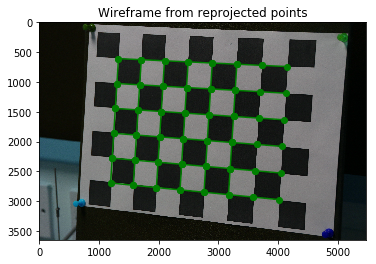

In [81]:
idx = [7,15,23,31,39,47]
idx1 = [5,11,17,23,29,35,41,47]

generate_wireframe(idx, idx1, projected_points, img1)

[1.32567303e+03 6.07838364e+02 1.00000000e+00]


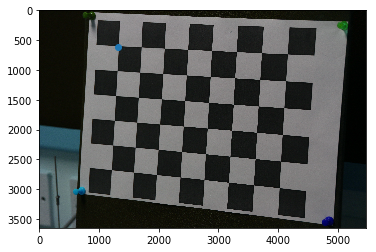

In [82]:
origin = [0,0,0,1]
img_origin = np.matmul(P, origin)
img_origin = img_origin/img_origin[2]
print(img_origin)
plt.scatter(img_origin[0], img_origin[1])
plt.imshow(img1)
plt.show()

### Correcting for radial distortion
- Images taken by a camera might seem to be distorted due to radial or tangential distortion.
- Here is an example of the original and undistorted images side by side.

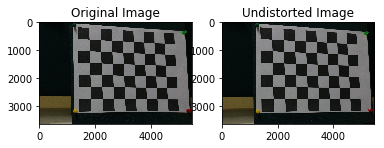

In [83]:
I = cv2.imread(images[6])[...,::-1]
I_undistort = cv2.undistort(I,mtx,dist)
plt.subplot(1,2,1)
plt.imshow(I)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(I_undistort)
plt.title('Undistorted Image')
plt.show()

- Let's calibrate the camera and undistort the image `Fig1.png`.
- Using the parameters returned by the calibrate Camera function we can rectify the distorted image.

In [84]:
img1 = cv2.imread('./data/Fig1.png')
# img_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# temp = [[-1,0,0], [0,-1,0], [0,0,1]]


- Similar to the first problem, let's compute the 2D-3D correspondences manually for the image 'Fig1.png'

In [29]:
# worldcoo = [ [0,0,0], [56,28,0], [56,84,0], [84,84,0], [112,56,0],
#              [0,28,28], [0,56,84], [0,56,112], [0,112,84], [0,112,112],
#              [140,140,0], [0,140,140], [0,168,112], [0,140,168]
#            ]

# imagecoo = [ [986,25], [1229,246], [1226,586], [1356,629], [1504,495],
#              [856,216], [586,448], [433, 484], [593,788], [444,838],
#              [1639, 1081], [298,1066], [461,1178], [133,1124]
#            ]

# worldcoo = [ [0,0,0], [56,28,0], [56,84,0], [84,84,0], [112,56,0],
#              [0,28,28], [0,56,84], [0,56,112], [0,112,84], [0,112,112],
#              [0,28,0], [56,0,0], [112,84,0], [84,56,0], [84,112,0],
#              [0,28,56], [0,56,28], [0,56,56], [0,112,0], [0,112,28]
#            ]

# # (0,112,56)

# imagecoo = [ [986,25], [1229,246], [1226,586], [1356,629], [1504,495],
#              [856,216], [586,448], [433, 484], [593,788], [444,838],
#              [987,190], [1235,72], [1500,675], [1359,454], [1352,797],
#              [1104, 384], [1232,245], [727,411], [986,664], [861,699]
#            ]

worldcoo = [ [0,0,0], [56,28,0], [56,84,0], [84,84,0], 
             [0,28,28], [0,56,84], [0,56,112]
           ]

imagecoo = [ [986,25], [1229,246], [1226,586], [1356,629],
             [856,216], [586,448], [433, 484]
           ]
worldcoo = np.array(worldcoo)
imagecoo = np.array(imagecoo)

In [30]:
worldcoo = worldcoo.astype('float32')
imagecoo = imagecoo.astype('float32')
print(worldcoo)

[[  0.   0.   0.]
 [ 56.  28.   0.]
 [ 56.  84.   0.]
 [ 84.  84.   0.]
 [  0.  28.  28.]
 [  0.  56.  84.]
 [  0.  56. 112.]]


In [31]:
Proj = compute_DLT(worldcoo, imagecoo)
H = Proj[:3,:3]
Q, R = np.linalg.qr(np.linalg.inv(H))
Rotation = Q.T
K = np.linalg.inv(R)
K = K/K[2,2]

# K[1][2] = -1 * K[1][2]
K[0][1] = 0
with np.printoptions(suppress=True): print('The Camera matrix is \n', K)


The Camera matrix is 
 [[3572.77231951    0.          763.64115878]
 [   0.         3539.74098362  553.74805806]
 [   0.            0.            1.        ]]


In [32]:
# img_gray.shape[::-1]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([worldcoo], [imagecoo], (img1.shape[1], img1.shape[0]), 
                                                    K, None, None, 
                                                    flags=(cv2.CALIB_USE_INTRINSIC_GUESS))


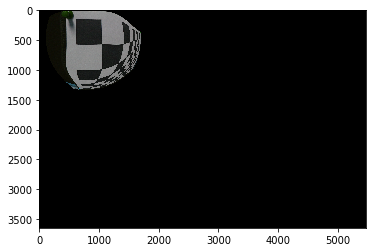

In [33]:
img_undistorted = cv2.undistort(img1, mtx, dist)
plt.imshow(img_undistorted)

### Hands On! 
- I'm going to use the inbuilt camera of my iPhone 6 for this one! 
- I took a printout of a checkerboard, and took pictures of it with my iPhone camera. 
- Let's perform camera calibration by applying DLT and by using Zhang's method.  

In [90]:
my_images = ['./data/my_camera/1.JPG', './data/my_camera/4.JPG', './data/my_camera/5.JPG', 
          './data/my_camera/6.JPG', './data/my_camera/7.JPG', './data/my_camera/8.JPG',
          './data/my_camera/9.JPG', 
         ]

In [91]:
x, y, world_points = generate_world_points(6, 9)
my_objpoints, my_imgpoints = generate_image_points(my_images, world_points, 6,9)

In [92]:
mtx, dist, rvecs, tvecs = calibrate(my_images, my_objpoints, my_imgpoints)

In [93]:
print('Reprojection Error:', ret)
print ('\nCamera Calibration Matrix:')
with np.printoptions(suppress=True): print(mtx)

Reprojection Error: 1.258530452451424

Camera Calibration Matrix:
[[3022.84464439    0.         1275.11356856]
 [   0.         3007.20763198 1635.81102083]
 [   0.            0.            1.        ]]


In [94]:
print('\nDistortion Parameters:')
with np.printoptions(suppress=True): print(dist)

print('\nRotation Vectors for the images are:')
with np.printoptions(suppress=True): print(rvecs)

print('\nTranslation Vectors for the images are:')
with np.printoptions(suppress=True): print(tvecs)


Distortion Parameters:
[[ 0.07935875 -0.61050053 -0.00032182  0.00318814  3.49364568]]

Rotation Vectors for the images are:
[array([[ 0.01712354],
       [ 0.1409937 ],
       [-3.12161075]]), array([[-0.38267963],
       [ 0.09480152],
       [ 3.08151162]]), array([[ 0.05761599],
       [-0.0562548 ],
       [ 2.99096295]])]

Translation Vectors for the images are:
[array([[ 1.78311945],
       [ 4.98925412],
       [14.68325852]]), array([[ 2.5604822 ],
       [ 4.18834307],
       [15.30102181]]), array([[ 2.90699565],
       [ 4.45381933],
       [15.98674185]])]


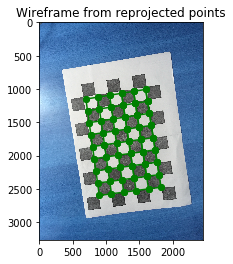

In [95]:
r =  rvecs[2]
R = (eulerAnglesToRotationMatrix(r))
world_points_1 = np.hstack((x, y, np.zeros((54,1)), np.ones((54,1)))).astype(np.float32)

temp1 = np.zeros((3,4))
temp1[0:3,0:3] = R[0:3,0:3]
temp1[:,3] = tvecs[2][:,0]
P = np.matmul(mtx,temp1)
P = P/P[2,3]
projected_points = []
for i in range(54):
    projection = np.matmul(P,np.transpose(world_points_1[i,:]))
    projection = projection/projection[2]
    projected_points.append(projection[0:2])

projected_points = np.asarray(projected_points)

idx = [5,11,17,23,29,35,41,47,53]
idx1 = [8,17,26,35,44,53]

imgtry = cv2.imread(my_images[5])
generate_wireframe(idx, idx1, projected_points, imgtry )

### DLT based calibration for my camera

- We take 3 images, varying focus. 
- Here's one:

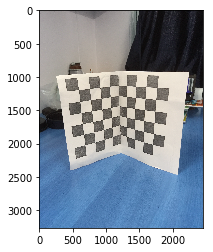

In [96]:
im5 = cv2.imread('./data/my_camera/folded/1.jpg')
im6 = cv2.imread('./data/my_camera/folded/2.jpg')
im7 = cv2.imread('./data/my_camera/folded/3.jpg')
plt.imshow(im5)

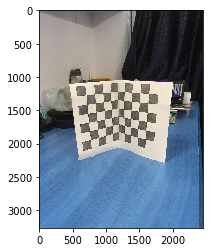

In [97]:
plt.imshow(im6)

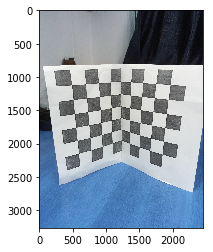

In [98]:
plt.imshow(im7)

In [99]:
worldcoo1 = [ (0,0,0), (56,28,0), (56,84,0), (84,84,0), (112,56,0),
             (0,28,28), (0,56,84), (0,56,112), (0,112,84), (0,112,112) 
           ]

imagecoo1 = [ (1193, 1138), (1443, 1319), (1437, 1645), (1574,1672), (1740,1527),
             (1069,1313), (795, 1525), (635, 1548), (829,1841), (673,1879)
           ]

worldcoo2 = [ (0,0,0), (56,28,0), (56,84,0), (84,84,0),
             (0,28,28), (0,56,84), (0,56,112)
           ]

imagecoo2 = [ (1182, 1124), (1388,1376), (1378,1639), (1488,1659),
              (1080,1369), (861,1537), (734,1557)
            ]

imagecoo3 = [ (1229,1076), (1542,1305), (1518, 1703), (1693,1739),
              (1078,1291), (739,1536), (536,1568)
            ]

In [100]:
P1 = compute_DLT(worldcoo1, imagecoo1)
H = P1[:,:3]
K, R = linalg.rq(H)
K = K/K[2,2]
t = np.dot(-1*np.linalg.inv(H), P1[:,3])
with np.printoptions(suppress=True): print('The Camera matrix is \n', K)

The Camera matrix is 
 [[ 2318.20344341    11.88793088  1163.05506384]
 [    0.         -2126.47943779  1948.46578756]
 [    0.             0.             1.        ]]


In [101]:
P2 = compute_DLT(worldcoo2, imagecoo2)
H = P2[:,:3]
K, R = linalg.rq(H)
K = K/K[2,2]
t = np.dot(-1*np.linalg.inv(H), P2[:,3])
with np.printoptions(suppress=True): print('The Camera matrix is \n', K)

The Camera matrix is 
 [[ 927.57079116 -143.05606309 1219.89963307]
 [   0.         -477.91325886 2178.17798605]
 [   0.            0.            1.        ]]


In [102]:
P3 = compute_DLT(worldcoo2, imagecoo3)
H = P3[:,:3]
K, R = linalg.rq(H)
K = K/K[2,2]
t = np.dot(-1*np.linalg.inv(H), P3[:,3])
with np.printoptions(suppress=True): print('The Camera matrix is \n', K)

The Camera matrix is 
 [[ 2510.38536762    12.4844985   1228.88130378]
 [    0.         -2281.28958599  2073.8639773 ]
 [    0.             0.             1.        ]]
